Training model...
RMSE (on training data):
  period 00 : 218.42
  period 01 : 200.70
  period 02 : 186.65
  period 03 : 176.49
  period 04 : 171.22
  period 05 : 168.43
  period 06 : 168.04
  period 07 : 169.10
  period 08 : 170.08
  period 09 : 171.94
Model training finished.


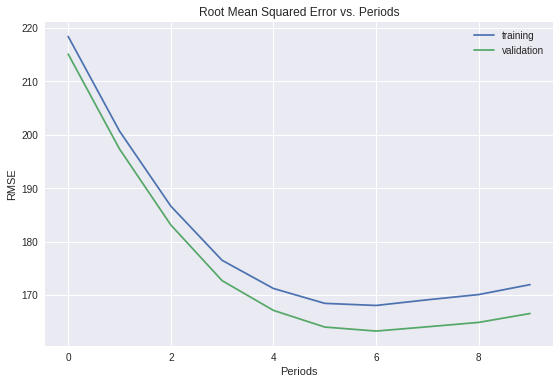

In [8]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://dl.google.com/mlcc/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
   np.random.permutation(california_housing_dataframe.index))


def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels
  
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
            for my_feature in input_features])

def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model of one feature.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  """
  training_my_feature = training_examples
  training_my_feature_data = california_housing_dataframe[training_my_feature]
  training_my_label = training_targets
  training_targets = california_housing_dataframe[training_my_label]

  validation_my_feature = validation_examples
  validation_my_feature_data = california_housing_dataframe[[validation_my_feature]]
  validation_my_label = validation_targets
  validation_targets = california_housing_dataframe[validation_my_label]
   """ 

  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  
  # 1. Create input functions.
  """training_input_fn = lambda:my_input_fn(training_my_feature, training_targets, batch_size = batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_my_feature_data, training_targets, num_epochs=1, shuffle=False)
  validation_input_fn = lambda:my_input_fn(validation_my_feature, validation_targets, batch_size = batch_size)
  predict_validation_input_fn = lambda: my_input_fn(validation_my_feature_data, validation_targets, num_epochs=1, shuffle=False)
  """
  training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets["median_house_value"], 
      batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets["median_house_value"], 
      num_epochs=1, 
      shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(
      validation_examples, validation_targets["median_house_value"], 
      num_epochs=1, 
      shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # 2. Take a break and compute predictions.
    """training_predictions = linear_regressor.predict(input_fn=training_input_fn)
    training_predictions = np.array([item['training_predictions'][0] for item in training_predictions])
    validation_predictions = linear_regressor.predict(input_fn=validation_input_fn)
    validation_predictions = np.array([item['validation_predictions'][0] for item in validation_predictions])
    """
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor



linear_regressor = train_model(
    learning_rate=0.00003,
    steps=500,
    batch_size=5,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)